In [1]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter

import matplotlib.pyplot as plt
%matplotlib inline

### Survival Analysis with Cox Model - AF Risk Prediction 

In [2]:
pred_file = "predicted_af_fdset_30Mar.csv"
pred_id_col = "exam_ids"
pred_class_col = "predicted_class"
prob_class3 = "prob_class3_norm"

exams_info_file = "traces100pc_threeClasses_time.csv"
exam_id_col = "id_exam"
class_col = "exam_class"

com_file = "comorbidities.csv"

In [3]:
# Read predicted csv file
pred_df = pd.read_csv(pred_file, index_col=pred_id_col)
pred_df.drop(columns='exam_ids.1', inplace=True)
pred_index = pred_df.index
pred_df.head(10)

,predicted_class,prob_class1,prob_class2,prob_class3,prob_class1_norm,prob_class3_norm
exam_ids,,,,,,
21284,1.0,0.998970,0.000035,0.000994,0.999006,0.000994
924386,1.0,0.995386,0.000073,0.004541,0.995459,0.004541
2939231,1.0,0.990075,0.001023,0.008902,0.991089,0.008911
761745,1.0,0.999566,0.000023,0.000411,0.999589,0.000411
713438,1.0,0.999525,0.000031,0.000444,0.999556,0.000444
3181141,1.0,0.974425,0.010703,0.014872,0.984967,0.015033
2735976,1.0,0.996727,0.000202,0.003070,0.996929,0.003071
2975924,2.0,0.050890,0.906287,0.042822,0.543045,0.456955
298440,1.0,0.999336,0.000084,0.000580,0.999420,0.000580


In [4]:
# Read exams info file
exams_df = pd.read_csv(exams_info_file, index_col = exam_id_col)
exams_df.drop(columns='Unnamed: 0', inplace=True)
exams_df.head(10)

,id_patient,age,sex,AF,exam_class,split,time
id_exam,,,,,,,
29855,1303179,63,F,0,1,train,37
21284,149539,68,F,0,1,test,148
749729,445398,42,M,0,1,train,4
371322,68340,59,M,0,1,train,20
1384433,10854,48,F,0,1,valid,45
3200399,110344,38,F,0,1,train,224
603726,1464955,60,M,0,1,train,141
3187610,1024979,30,F,0,1,train,256
805692,56645,33,M,0,1,train,61


In [5]:
# Keep exams that are in the predicted file
exams_df = exams_df.reindex(pred_index, fill_value=False, copy=True) # Keep ids that are in pred_csv file
print(exams_df.isnull().sum() ==0) # It should print True, all ids in pred_file should be in exams_info_file
print("Number of samples in both files are equal now: ", len(pred_df) == len(exams_df))

id_patient    True
age           True
sex           True
AF            True
exam_class    True
split         True
time          True
dtype: bool
Number of samples in both files are equal now:  True


In [6]:
exams_df[class_col].value_counts()

1    191665
3      3691
2      3053
Name: exam_class, dtype: int64

In [7]:
classes1n3_mask = exams_df[class_col] != 2
sum(~classes1n3_mask)

3053

In [8]:
# Removing rows corresponding to true class equal 2
pred_df = pred_df[classes1n3_mask]
exams_df = exams_df[classes1n3_mask]
print("Number of samples in both files are still equal: ", len(pred_df) == len(exams_df))
exams_df[class_col].value_counts()

Number of samples in both files are still equal:  True


1    191665
3      3691
Name: exam_class, dtype: int64

In [9]:
# Add columns/features to exams_df
exams_df['is_male'] = exams_df['sex'] == 'M'
exams_df['AF_event'] = exams_df[class_col] == 3
print(sum(exams_df['AF_event']))
exams_df.head(5)

3691


,id_patient,age,sex,AF,exam_class,split,time,is_male,AF_event
exam_ids,,,,,,,,,
21284,149539,68,F,0,1,test,148,False,False
924386,1043714,69,F,0,1,test,39,False,False
2939231,50085,72,F,0,1,test,121,False,False
761745,11939,59,F,0,1,test,53,False,False
713438,1245882,47,M,0,1,test,128,True,False


### Add comorbidities information to the 'exams_df' dataframe


In [10]:
# Load data with comorbidities information

db_com = pd.read_csv('comorbidities.csv')

In [11]:
db_com.set_index("id_exam", inplace = True)
db_com.head(5)

,id_patient,diureticos,digital,betabloqueadores,inibidoresdaenzimaconversora,amiodarona,bloqueadoresdecalcio,obesidade,diabetesmellitus,tabagismo,revascularizacamiocardicaprevia,historicofamiliardoencacoronariana,infartomiocardioprevio,dislipidemia,doencarenalcronica,doencapulmonarcronica,doencadechagas,hipertencaoarterial
id_exam,,,,,,,,,,,,,,,,,,
3084775,921353,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3084748,57510,True,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,True
3084384,156042,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
3084317,91017,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3084241,348744,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [12]:
# Merging the two dataframes by keeping exams from the 'exams_df' dataframe

exams_com_df = exams_df.join(db_com, rsuffix='_other')

In [13]:
exams_com_df.head(5)

,id_patient,age,sex,AF,exam_class,split,time,is_male,AF_event,id_patient_other,...,diabetesmellitus,tabagismo,revascularizacamiocardicaprevia,historicofamiliardoencacoronariana,infartomiocardioprevio,dislipidemia,doencarenalcronica,doencapulmonarcronica,doencadechagas,hipertencaoarterial
exam_ids,,,,,,,,,,,,,,,,,,,,,
21284,149539,68,F,0,1,test,148,False,False,149539.0,...,False,False,False,False,False,False,False,False,False,False
924386,1043714,69,F,0,1,test,39,False,False,1043714.0,...,False,True,False,True,False,False,False,False,False,True
2939231,50085,72,F,0,1,test,121,False,False,50085.0,...,False,False,False,False,False,False,False,False,True,False
761745,11939,59,F,0,1,test,53,False,False,11939.0,...,False,False,False,False,False,False,False,False,False,True
713438,1245882,47,M,0,1,test,128,True,False,1245882.0,...,True,False,False,False,False,True,False,False,False,True


In [14]:
exams_com_df.columns

Index(['id_patient', 'age', 'sex', 'AF', 'exam_class', 'split', 'time',
       'is_male', 'AF_event', 'id_patient_other', 'diureticos', 'digital',
       'betabloqueadores', 'inibidoresdaenzimaconversora', 'amiodarona',
       'bloqueadoresdecalcio', 'obesidade', 'diabetesmellitus', 'tabagismo',
       'revascularizacamiocardicaprevia', 'historicofamiliardoencacoronariana',
       'infartomiocardioprevio', 'dislipidemia', 'doencarenalcronica',
       'doencapulmonarcronica', 'doencadechagas', 'hipertencaoarterial'],
      dtype='object')

In [15]:
column_list = ['age', 'is_male', 'AF_event', 'time', 'diureticos', 'betabloqueadores', 'inibidoresdaenzimaconversora', 
               'amiodarona', 'bloqueadoresdecalcio', 'obesidade', 'diabetesmellitus', 'tabagismo',
               'revascularizacamiocardicaprevia', 'historicofamiliardoencacoronariana', 'infartomiocardioprevio',
               'dislipidemia', 'doencarenalcronica', 'doencapulmonarcronica', 'doencadechagas', 'hipertencaoarterial']

In [16]:
# Make a survival analysis dataset
df1 = exams_com_df.loc[:, column_list].rename(columns={"time": "weeks"})
#df1 = exams_df.loc[:, ['AF_event', 'time']].rename(columns={"time": "weeks"})
sa_df = pred_df.loc[:, [prob_class3]].rename(columns={prob_class3: "class3_prob"})
sa_df = pd.concat([sa_df, df1], axis=1)

In [17]:
len(sa_df)

195356

In [18]:
sa_df[sa_df['diureticos'].isnull()].shape

(21, 21)

In [19]:
#sa_df.isnull().sum()
# Drop samples with null values
sa_df.dropna(inplace=True)

In [20]:
print(sa_df['AF_event'].value_counts())
len(sa_df)

False    191645
True       3690
Name: AF_event, dtype: int64


195335

In [21]:
sa_df.head(5)

,class3_prob,age,is_male,AF_event,weeks,diureticos,betabloqueadores,inibidoresdaenzimaconversora,amiodarona,bloqueadoresdecalcio,...,diabetesmellitus,tabagismo,revascularizacamiocardicaprevia,historicofamiliardoencacoronariana,infartomiocardioprevio,dislipidemia,doencarenalcronica,doencapulmonarcronica,doencadechagas,hipertencaoarterial
exam_ids,,,,,,,,,,,,,,,,,,,,,
21284,0.000994,68,False,False,148,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
924386,0.004541,69,False,False,39,True,False,False,False,False,...,False,True,False,True,False,False,False,False,False,True
2939231,0.008911,72,False,False,121,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
761745,0.000411,59,False,False,53,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
713438,0.000444,47,True,False,128,True,False,False,False,False,...,True,False,False,False,False,True,False,False,False,True


In [22]:
sa_df.shape

(195335, 21)

### Kaplan Meier

In [23]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

#### considering 4 probability groupes

In [24]:
km_df2 = sa_df.copy()
# Make columns of bins for probabilities and ages
bins = pd.IntervalIndex.from_tuples([(0, 0.1), (0.1, 0.4), (0.4, 0.7), (0.7, 1)])
#bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
km_df2['prob3_bins'] = pd.cut(km_df2['class3_prob'], bins, precision=5).cat.codes
#sa_df2['age_strata'] = pd.cut(sa_df2['age'], np.arange(15, 106, 10)).cat.codes
km_df2['age_bins'] = pd.cut(km_df2['age'], np.arange(15, 106, 10)).cat.codes
km_df2.head()

,class3_prob,age,is_male,AF_event,weeks,diureticos,betabloqueadores,inibidoresdaenzimaconversora,amiodarona,bloqueadoresdecalcio,...,revascularizacamiocardicaprevia,historicofamiliardoencacoronariana,infartomiocardioprevio,dislipidemia,doencarenalcronica,doencapulmonarcronica,doencadechagas,hipertencaoarterial,prob3_bins,age_bins
exam_ids,,,,,,,,,,,,,,,,,,,,,
21284,0.000994,68,False,False,148,False,False,False,False,False,...,False,False,False,False,False,False,False,False,0,5
924386,0.004541,69,False,False,39,True,False,False,False,False,...,False,True,False,False,False,False,False,True,0,5
2939231,0.008911,72,False,False,121,False,False,False,False,False,...,False,False,False,False,False,False,True,False,0,5
761745,0.000411,59,False,False,53,False,False,False,False,False,...,False,False,False,False,False,False,False,True,0,4
713438,0.000444,47,True,False,128,True,False,False,False,False,...,False,False,False,True,False,False,False,True,0,3


inf
248.0
82.0
40.0


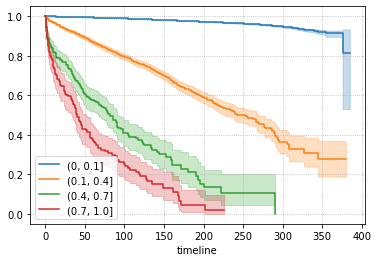

In [25]:
# Survival curves considering 4 probability groupes
kmf2 = KaplanMeierFitter()
ax2 = plt.subplot(111)
label_list2 = ['(0, 0.1]', '(0.1, 0.4]','(0.4, 0.7]', '(0.7, 1.0]']
for i in range(4):
    kmf2.fit(km_df2[km_df2['prob3_bins']==i]['weeks'], km_df2[km_df2['prob3_bins']==i]['AF_event'], label= label_list2[i])
    print(kmf2.median_survival_time_)
    kmf2.plot_survival_function(ax=ax2)
    ax2.grid(linestyle=':')
#ax2.set_xlabel("timeline (weeks)")
#ax2.set_ylabel("survival probability")
    

inf
248.0
82.0
40.0


Text(0, 0.5, 'survival probability')

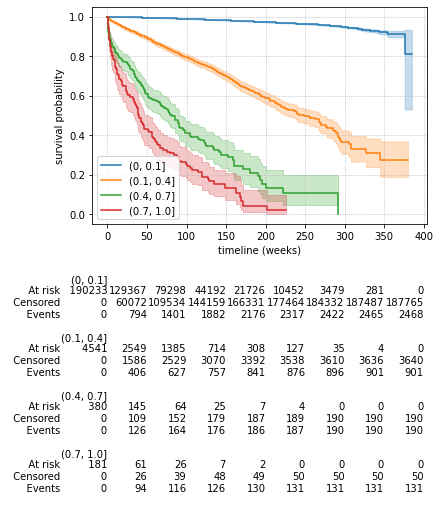

In [26]:
# Survival curves considering 4 probability groupes plus risk counts
kmf3 = {}
fig = plt.figure()
ax3 = plt.subplot(111)
label_list3 = ['(0, 0.1]', '(0.1, 0.4]','(0.4, 0.7]', '(0.7, 1.0]']
for i in range(4):
    kmf3[i] = KaplanMeierFitter()
    kmf3[i].fit(km_df2[km_df2['prob3_bins']==i]['weeks'], km_df2[km_df2['prob3_bins']==i]['AF_event'], label= label_list3[i])
    print(kmf3[i].median_survival_time_)
    ax3 = kmf3[i].plot_survival_function(ax=ax3)
   
    #plt.tight_layout()

from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf3[0], kmf3[1], kmf3[2], kmf3[3], ax=ax3, fig=fig)
#plt.tight_layout()
ax3.grid(linestyle=':')
ax3.set_xlabel("timeline (weeks)")
ax3.set_ylabel("survival probability")
#plt.tight_layout()    
    
#kmf.plot_survival_function(at_risk_counts=True)
#plt.tight_layout()
#plt.savefig('KM_Survival_curves.pdf')
#fig.savefig('KM_Survival_curves.pdf')
#plt.show()

### Cox Proportional Hazard model: 

#### Using Dummy Coding for predicted probabilities

#### Considering only three dummy codes: (0.1, 0.4], (0.4, 0.7], (0.7, 1.0]

In [23]:
dc_df2 = sa_df.copy()

In [24]:
# Make columns of bins for probabilities and ages
bins = pd.IntervalIndex.from_tuples([(0, 0.1), (0.1, 0.4), (0.4, 0.7), (0.7, 1)])
dc_df2['prob3_bins'] = pd.cut(dc_df2['class3_prob'], bins, precision=5)
dc_df2['age_bins'] = pd.cut(dc_df2['age'], np.arange(15, 106, 10)).cat.codes
#dummies_prob3 = pd.get_dummies(dc_df["prob3_bins"], prefix = 'quantile')
three_dummies_prob3 = pd.get_dummies(dc_df2["prob3_bins"])
#dc_df.head()

In [25]:
dc_df2 = pd.concat([dc_df2, three_dummies_prob3], axis = 1)
dc_df2 = dc_df2.drop(dc_df2.columns[23], axis = 1) # Change number "7" to point to the range (0,0.1] maybe "23"
dc_df2 = dc_df2.drop(['class3_prob', 'age', 'prob3_bins'], axis = 1)
dc_df2.head()

,is_male,AF_event,weeks,diureticos,betabloqueadores,inibidoresdaenzimaconversora,amiodarona,bloqueadoresdecalcio,obesidade,diabetesmellitus,...,infartomiocardioprevio,dislipidemia,doencarenalcronica,doencapulmonarcronica,doencadechagas,hipertencaoarterial,age_bins,"(0.1, 0.4]","(0.4, 0.7]","(0.7, 1.0]"
exam_ids,,,,,,,,,,,,,,,,,,,,,
21284,False,False,148,False,False,False,False,False,False,False,...,False,False,False,False,False,False,5,0,0,0
924386,False,False,39,True,False,False,False,False,False,False,...,False,False,False,False,False,True,5,0,0,0
2939231,False,False,121,False,False,False,False,False,False,False,...,False,False,False,False,True,False,5,0,0,0
761745,False,False,53,False,False,False,False,False,False,False,...,False,False,False,False,False,True,4,0,0,0
713438,True,False,128,True,False,False,False,False,False,True,...,False,True,False,False,False,True,3,0,0,0


In [26]:
dc_df2.columns

Index([                           'is_male',
                                 'AF_event',
                                    'weeks',
                               'diureticos',
                         'betabloqueadores',
             'inibidoresdaenzimaconversora',
                               'amiodarona',
                     'bloqueadoresdecalcio',
                                'obesidade',
                         'diabetesmellitus',
                                'tabagismo',
          'revascularizacamiocardicaprevia',
       'historicofamiliardoencacoronariana',
                   'infartomiocardioprevio',
                             'dislipidemia',
                       'doencarenalcronica',
                    'doencapulmonarcronica',
                           'doencadechagas',
                      'hipertencaoarterial',
                                 'age_bins',
                                 (0.1, 0.4],
                                 (0.4, 0.7],
          

#### Model adjusted with age, sex, plus comorbidities

In [43]:
# Training the model with dummy coded covarietes

cph_dc2 = CoxPHFitter(penalizer=0.1)
cph_dc2.fit(dc_df2, duration_col='weeks', event_col='AF_event', step_size=0.20)

C:\Users\Administrotor\anaconda3\lib\site-packages\lifelines\utils\__init__.py:1103: ConvergenceWarning: Column(s) ['inibidoresdaenzimaconversora', 'bloqueadoresdecalcio'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


<lifelines.CoxPHFitter: fitted with 195335 total observations, 191645 right-censored observations>

In [44]:
cph_dc2.print_summary()

<lifelines.CoxPHFitter: fitted with 195335 total observations, 191645 right-censored observations>
             duration col = 'weeks'
                event col = 'AF_event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 195335
number of events observed = 3690
   partial log-likelihood = -40126.88
         time fit was run = 2023-08-05 11:49:27 UTC

---
                                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                  
is_male                              0.08       1.08       0.01             0.05             0.11                 1.05                 1.11
diureticos                           0.04       1.05       0.02             0.01             0.07                 1.01                 1.08
betabloqueadores                     0.03       1.03       0.02            -0.01             0.08                 0.99                 1.08
inibidoresdaenzimaconversora         0.48       1.62       0.76            -1.01             1.98                 0.36                 7.23
amiodarona                           0.44       1.56       0.07             0.31             0.57                 1.37                 1.78
bloqueadoresdecalcio                -0.06       0.94       1.02            -2.07             1.94                 0.13                 6.96
obesidade                           -0.01       0.99       0.03            -0.06             0.05                 0.94                 1.05
diabetesmellitus                     0.01       1.01       0.02            -0.04             0.06                 0.96                 1.06
tabagismo                           -0.03       0.97       0.03            -0.09             0.02                 0.92                 1.02
revascularizacamiocardicaprevia      0.13       1.14       0.11            -0.08             0.35                 0.92                 1.42
historicofamiliardoencacoronariana  -0.01       0.99       0.02            -0.05             0.02                 0.95                 1.02
infartomiocardioprevio               0.06       1.06       0.06            -0.07             0.18                 0.94                 1.20
dislipidemia                        -0.03       0.97       0.03            -0.09             0.04                 0.91                 1.04
doencarenalcronica                   0.01       1.01       0.10            -0.18             0.20                 0.84                 1.22
doencapulmonarcronica                0.09       1.10       0.08            -0.06             0.25                 0.94                 1.28
doencadechagas                       0.12       1.12       0.03             0.05             0.18                 1.05                 1.20
hipertencaoarterial                  0.04       1.04       0.01             0.01             0.06                 1.01                 1.07
age_bins                             0.08       1.08       0.00             0.07             0.08                 1.07                 1.09
(0.1, 0.4]                           1.38       3.99       0.04             1.31             1.46                 3.71                 4.30
(0.4, 0.7]                           3.02      20.44       0.09             2.83             3.20                16.98                24.62
(0.7, 1.0]                           3.71      40.87       0.11             3.49             3.93                32.83                50.87

                                       z      p   -log2(p)
covariate                                                 
is_male                             5.89 <0.005      27.91
diureticos                          2.85 <0.005       7.86
betabloqueadores                    1.45   0.15       2.75
inibidoresdaenzimaconversora        0.63   0.53

In [45]:
# Checking the proportional hazards assumption
cph_dc2.check_assumptions( dc_df2, p_value_threshold=0.05, show_plots=False)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



C:\Users\Administrotor\anaconda3\lib\site-packages\lifelines\fitters\mixins.py:108: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  for variable in self.params_.index & (columns or self.params_.index):


<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 195335 total observations, 191645 right-censored observations>
         test_name = proportional_hazard_test

---
                                         test_statistic      p  -log2(p)
(0.1, 0.4]                         km             22.35 <0.005     18.75
                                   rank           23.95 <0.005     19.95
(0.4, 0.7]                         km             39.13 <0.005     31.23
                                   rank           77.85 <0.005     59.64
(0.7, 1.0]                         km             29.45 <0.005     24.06
                                   rank           54.70 <0.005     42.69
age_bins                           km              0.70   0.40      1.31
                                   rank            0.79   0.37      1.42
amiodarona                         km              0.13   0.72      0.48
                                   rank            0.30   0.58      0.78
betabloqueadores                   km              1.50   0.22      2.18
                                   rank            1.06   0.30      1.72
bloqueadoresdecalcio               km              0.00   0.96      0.06
                                   rank            0.01   0.94      0.09
diabetesmellitus                   km              0.42   0.52      0.95
                                   rank            0.61   0.43      1.21
dislipidemia                       km              0.01   0.91      0.14
                                   rank            0.00   0.96      0.06
diureticos                         km              0.45   0.50      0.99
                                   rank            0.30   0.59      0.77
doencadechagas                     km              1.10   0.29      1.76
                                   rank            0.46   0.50      1.00
doencapulmonarcronica              km              0.00   0.99      0.02
                                   rank            0.10   0.76      0.40
doencarenalcronica                 km              0.00   0.95      0.08
                                   rank            0.01   0.92      0.12
hipertencaoarterial                km              3.96   0.05      4.42
                                   rank            3.62   0.06      4.13
historicofamiliardoencacoronariana km              0.00   0.97      0.05
                                   rank            0.01   0.93      0.10
infartomiocardioprevio             km              0.10   0.75      0.41
                                   rank            0.28   0.60      0.74
inibidoresdaenzimaconversora       km              0.11   0.74      0.44
                                   rank            0.19   0.67      0.59
is_male                            km              1.22   0.27      1.90
                                   rank            0.94   0.33      1.59
obesidade                          km              0.01   0.91      0.13
                                   rank            0.15   0.69      0.53
revascularizacamiocardicaprevia    km              0.21   0.65      0.62
                                   rank            0.35   0.56      0.85
tabagismo                          km              0.09   0.76      0.39
                                   rank            0.01   0.94      0.09



1. Variable 'hipertencaoarterial' failed the non-proportional test: p-value is 0.0467.

   Advice: with so few unique values (only 2), you can include `strata=['hipertencaoarterial', ...]`
in the call in `.fit`. See documentation in link [E] below.

2. Variable '(0.1, 0.4]' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['(0.1, 0.4]', ...]` in the
call in `.fit`. See documentation in link [E] below.

3. Variable '(0.4, 0.7]' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['(0.4, 0.7]', ...]` in the
call in `.fit`. See documentation in link [E] below.

4. Variable '(0.7, 1.0]' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['(0.7, 1.0]', ...]` in the
call in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/

[]

<AxesSubplot:>

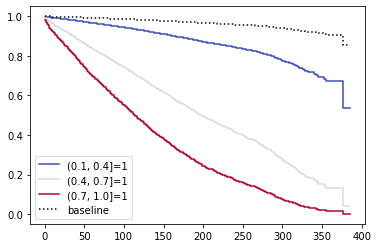

In [46]:
# Plotting survival curves

covariates= [dc_df2.columns[20], dc_df2.columns[21], dc_df2.columns[22]]  #  pointing to (0.1, 0.4), (0.4, 0.7), (0.7, 1)
#cph_dc.plot_partial_effects_on_outcome(covariates=covariates, values=np.eye(5))
cph_dc2.plot_partial_effects_on_outcome(covariates=covariates, values=np.eye(3), cmap='coolwarm') # from np.eye(4)

<AxesSubplot:>

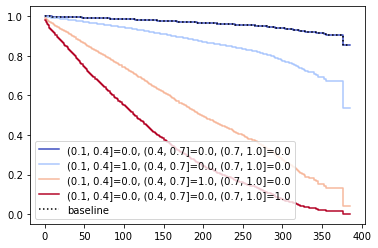

In [47]:
covariates= [dc_df2.columns[20], dc_df2.columns[21], dc_df2.columns[22]] 
val=np.eye(3)
val = np.append(np.array([[0,0,0]]),val, axis= 0)   # or np.vstack
label_list = ['(0, 0.1]', '(0.1, 0.4]','(0.4, 0.7]', '(0.7, 1.0]']
cph_dc2.plot_partial_effects_on_outcome(covariates=covariates, values=val, cmap='coolwarm', label=label_list)

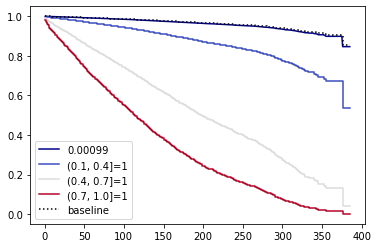

In [48]:
label_list = ['(0, 0.1]', '(0.1, 0.4]','(0.4, 0.7]', '(0.7, 1.0]']
ax5 = plt.subplot(111)
a = dc_df2.iloc[0]
#a.name = '(0.0,0.2]'
a.name = str(np.round(sa_df.iloc[0]['class3_prob'], 5)) # to double check
cph_dc2.predict_survival_function(a).plot(ax=ax5, color='darkblue')
cph_dc2.plot_partial_effects_on_outcome(covariates=covariates, values=np.eye(3), cmap='coolwarm', ax=ax5, label=label_list)
ax5.legend()
plt.show()

In [49]:
h_ratios2 = cph_dc2.hazard_ratios_
h_ratios2

covariate
is_male                                1.082953
diureticos                             1.045137
betabloqueadores                       1.033619
inibidoresdaenzimaconversora           1.622202
amiodarona                             1.560139
bloqueadoresdecalcio                   0.937822
obesidade                              0.990937
diabetesmellitus                       1.009545
tabagismo                              0.967836
revascularizacamiocardicaprevia        1.143628
historicofamiliardoencacoronariana     0.986023
infartomiocardioprevio                 1.060748
dislipidemia                           0.973427
doencarenalcronica                     1.008213
doencapulmonarcronica                  1.098380
doencadechagas                         1.122278
hipertencaoarterial                    1.038401
age_bins                               1.078018
(0.1, 0.4]                             3.994515
(0.4, 0.7]                            20.444048
(0.7, 1.0]                    

#### Model adjusted with only age and sex

In [29]:
dc_df3 = dc_df2.copy()
drop_list = ['diureticos', 'betabloqueadores', 'inibidoresdaenzimaconversora', 
               'amiodarona', 'bloqueadoresdecalcio', 'obesidade', 'diabetesmellitus', 'tabagismo',
               'revascularizacamiocardicaprevia', 'historicofamiliardoencacoronariana', 'infartomiocardioprevio',
               'dislipidemia', 'doencarenalcronica', 'doencapulmonarcronica', 'doencadechagas', 'hipertencaoarterial']
dc_df3 = dc_df3.drop(drop_list, axis = 1)
dc_df3.head()

,is_male,AF_event,weeks,age_bins,"(0.1, 0.4]","(0.4, 0.7]","(0.7, 1.0]"
exam_ids,,,,,,,
21284,False,False,148,5,0,0,0
924386,False,False,39,5,0,0,0
2939231,False,False,121,5,0,0,0
761745,False,False,53,4,0,0,0
713438,True,False,128,3,0,0,0


In [31]:
# Training the model with dummy coded covarietes, adjusted with age and sex

cph_dc3 = CoxPHFitter(penalizer=0.1)
cph_dc3.fit(dc_df3, duration_col='weeks', event_col='AF_event', step_size=0.20)

<lifelines.CoxPHFitter: fitted with 195335 total observations, 191645 right-censored observations>

In [32]:
cph_dc3.print_summary()

<lifelines.CoxPHFitter: fitted with 195335 total observations, 191645 right-censored observations>
             duration col = 'weeks'
                event col = 'AF_event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 195335
number of events observed = 3690
   partial log-likelihood = -40170.50
         time fit was run = 2023-08-05 19:04:33 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
is_male      0.08       1.08       0.01             0.05             0.11                 1.05                 1.11
age_bins     0.08       1.08       0.00             0.07             0.08                 1.07                 1.09
(0.1, 0.4]   1.40       4.06       0.04             1.33             1.48                 3.77                 4.37
(0.4, 0.7]   3.03      20.61       0.09             2.84             3.21                17.11                24.82
(0.7, 1.0]   3.75      42.34       0.11             3.53             3.97                33.99                52.74

               z      p   -log2(p)
covariate                         
is_male     5.82 <0.005      27.32
age_bins   18.57 <0.005     253.31
(0.1, 0.4] 37.02 <0.005     993.90
(0.4, 0.7] 31.89 <0.005     738.86
(0.7, 1.0] 33.43 <0.005     811.60
---
Concordance = 0.83
Partial AIC = 80351.00
log-likelihood ratio test = 2926.52 on 5 df
-log2(p) of ll-ratio test = inf

In [33]:
# Checking the proportional hazards assumption
cph_dc3.check_assumptions(dc_df3, p_value_threshold=0.05, show_plots=False)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



C:\Users\Administrotor\anaconda3\lib\site-packages\lifelines\fitters\mixins.py:108: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  for variable in self.params_.index & (columns or self.params_.index):


<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 195335 total observations, 191645 right-censored observations>
         test_name = proportional_hazard_test

---
                 test_statistic      p  -log2(p)
(0.1, 0.4] km             21.33 <0.005     17.98
           rank           23.76 <0.005     19.80
(0.4, 0.7] km             39.93 <0.005     31.82
           rank           79.25 <0.005     60.66
(0.7, 1.0] km             29.75 <0.005     24.28
           rank           54.73 <0.005     42.72
age_bins   km              0.91   0.34      1.55
           rank            1.00   0.32      1.65
is_male    km              1.18   0.28      1.85
           rank            0.88   0.35      1.53



1. Variable '(0.1, 0.4]' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['(0.1, 0.4]', ...]` in the
call in `.fit`. See documentation in link [E] below.

2. Variable '(0.4, 0.7]' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['(0.4, 0.7]', ...]` in the
call in `.fit`. See documentation in link [E] below.

3. Variable '(0.7, 1.0]' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['(0.7, 1.0]', ...]` in the
call in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyte

[]

<AxesSubplot:>

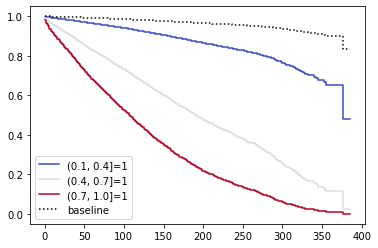

In [34]:
# Plotting survival curves

covariates3= [dc_df3.columns[4], dc_df3.columns[5], dc_df3.columns[6]]  # pointing to (0.1, 0.4), (0.4, 0.7), (0.7, 1)
#cph_dc.plot_partial_effects_on_outcome(covariates=covariates, values=np.eye(5))
cph_dc3.plot_partial_effects_on_outcome(covariates=covariates3, values=np.eye(3), cmap='coolwarm') 

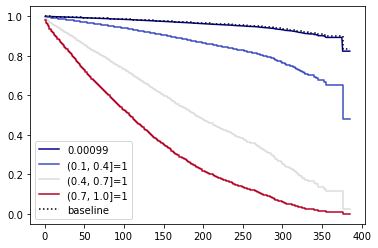

In [35]:
label_list3 = ['(0, 0.1]', '(0.1, 0.4]','(0.4, 0.7]', '(0.7, 1.0]']
ax7 = plt.subplot(111)
b = dc_df3.iloc[0]
b.name = str(np.round(sa_df.iloc[0]['class3_prob'], 5)) # to double check
cph_dc3.predict_survival_function(b).plot(ax=ax7, color='darkblue')
cph_dc3.plot_partial_effects_on_outcome(covariates=covariates3, values=np.eye(3), cmap='coolwarm', ax=ax7, label=label_list3)
ax7.legend()
plt.show()

In [36]:
h_ratios3 = cph_dc3.hazard_ratios_
h_ratios3

covariate
is_male        1.081916
age_bins       1.079122
(0.1, 0.4]     4.059950
(0.4, 0.7]    20.608692
(0.7, 1.0]    42.339362
Name: exp(coef), dtype: float64